# Two-link planar manipulator

Robot model diagram:
![diagram](diagram.png)

\begin{align*}
a_1 = a_2 &= 1 \, m \\
l_1 = l_2 &= 0.5 \, m \\
m_{l_1} = m_{l_2} &= 50 \, kg \\
I_{l_1} = I_{l_2} &= 10 \, kgm^2 \\
m_{m_1} = m_{m_2} &= 5 \, kg \\
I_{m_1} = I_{m_2} &= 0.01 \, kgm^2
\end{align*}

In [1]:
import numpy as np

import sympy as sym
from sympy.utilities.iterables import flatten
from sympy.physics.vector import init_vprinting, dynamicsymbols

from scipy.integrate import odeint
from scipy.optimize import minimize

import matplotlib.pyplot as plt

init_vprinting()

First, set up SymPy symbols and a dictionary containing their numerical values

In [2]:
t = dynamicsymbols._t
theta1, theta2 = dynamicsymbols('vartheta_1, vartheta_2')
theta1d, theta2d = dynamicsymbols('vartheta_1, vartheta_2', 1)
theta1dd, theta2dd = dynamicsymbols('vartheta_1, vartheta_2', 2)
tau1, tau2 = dynamicsymbols('tau_1, tau_2')
l1, l2 = sym.symbols('l_1, l_2', real=True)
a1, a2 = sym.symbols('a_1, a_2', real=True)
ml1, ml2 = sym.symbols('m_{l_1}, m_{l_2}', real=True)
xyz = ('x', 'y', 'z')
Il1 = sym.Matrix(3, 3, lambda i,j: sym.var('I_{1_{%s%s}}'%(xyz[i], xyz[j])) if i==j else 0)
Il2 = sym.Matrix(3, 3, lambda i,j: sym.var('I_{2_{%s%s}}'%(xyz[i], xyz[j])) if i==j else 0)
q = sym.Matrix([theta1, theta2])
gx, gy, gz = [sym.Symbol('g_{}'.format(i)) for i in xyz]
g = sym.Matrix([gx, gy, gz])
qd = sym.Matrix([theta1d, theta2d])
qdd = sym.Matrix([theta1dd, theta2dd])
tau = sym.Matrix([tau1, tau2])

In [3]:
numeric_values = {
    a1: 1,
    a2: 1,
    l1: 0.5,
    l2: 0.5,
    ml1: 50,
    ml2: 50,
}
numeric_values.update({x: 10 for x in [Il1[i,i] for i in range(3)]})
numeric_values.update({x: 10 for x in [Il2[i,i] for i in range(3)]})
numeric_values.update(dict(zip(g, [0, 9.82, 0])))

## Kinematics
Frame transformations:

In [4]:
def Rz(a):
    return sym.Matrix([[sym.cos(a), -sym.sin(a), 0],
                       [sym.sin(a), sym.cos(a),  0],
                       [0,          0,           1]])

T01 = sym.eye(4); T01[:3,:3] = Rz(theta1)
T12 = sym.eye(4); T12[:3,:3] = Rz(theta2); T12[0,3] = a1
T23 = sym.eye(4); T23[0,3] = a2

T1com1 = sym.eye(4); T1com1[0,3] = l1
T2com2 = sym.eye(4); T2com2[0,3] = l2

T02 = sym.simplify(T01 * T12)
T03 = sym.simplify(T02 * T23)
T0com1 = sym.simplify(T01 * T1com1)
T0com2 = sym.simplify(T02 * T2com2)

Angular velocities in each frame wrt. itself:

In [5]:
omega1 = sym.Matrix([0, 0, sym.diff(theta1)])
omega2 = T12[:3,:3].T * omega1 + sym.Matrix([0, 0, sym.diff(theta2)])
omega3 = T23[:3,:3].T * omega2 # + Matrix([0, 0, 0])
omega_com1 = T1com1[:3,:3].T * omega1 # + Matrix([0, 0, 0])
omega_com2 = T2com2[:3,:3].T * omega2 # + Matrix([0, 0, 0])

Linear velocities in each frame wrt. itself:

In [6]:
v1 = sym.Matrix([0, 0, 0])
v2 = T12[:3,:3].T * (v1 + omega1.cross(T12[:3,3]))
v3 = T23[:3,:3].T * (v2 + omega2.cross(T23[:3,3]))
v_com1 = T1com1[:3,:3].T * (v1 + omega1.cross(T1com1[:3,3]))
v_com2 = T2com2[:3,:3].T * (v2 + omega2.cross(T2com2[:3,3]))

Jacobian matrices for COM frames:

In [7]:
Jcom1_upper = T0com1[:3,3].jacobian((theta1, theta2))
Jcom1 = sym.Matrix([Jcom1_upper, (0,0),(0,0),(1,0)])
Jcom2_upper = T0com2[:3,3].jacobian((theta1, theta2))
Jcom2 = sym.Matrix([Jcom2_upper, (0,0),(0,0),(1,1)])

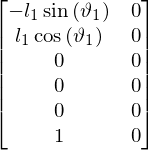

In [8]:
Jcom1

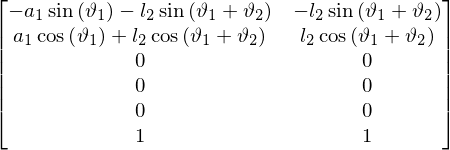

In [9]:
Jcom2

Which is the same as the velocity of frame "com2" seen wrt. frame "0":

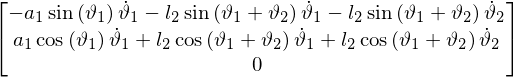

In [10]:
sym.simplify(T0com2[:3,:3] * v_com2)

Singularities:

In [11]:
detJcom2 = sym.simplify(sym.det(Jcom2[:2,:2]))
detJcom2

In [12]:
sym.solve(detJcom2, (theta2))

## Lagrangian

The Lagrangian is defined as
$$
\mathcal{L}(q,\dot{q}) = T(q,\dot{q}) - V(q)
$$

### Kinetic energy
$T$ is the kinetic energy function on the form
$$
T(q,\dot{q}) = \frac{1}{2} \dot{q}^T M(q) \dot{q}
$$

#### Inertia matrix, $M(q)$
$$
M(q) = \sum_{i=1}^n \left( m_i J_{v_i}^T J_{v_i} + J_{\omega_i}^T R_i I_i R_i^T J_{\omega_i} \right)
$$
where $J_{v_i}$ and $J_{\omega_i}$ are Jacobian matrices. $M$ is symmetric and positive definite for each $q \in \mathbb{R}^n$.

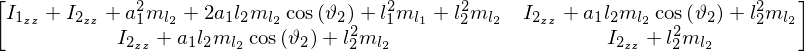

In [13]:
t1v = ml1 * Jcom1[:3,:].T * Jcom1[:3,:]
t1w = Jcom1[3:,:].T * T0com1[:3,:3] * Il1 * T0com1[:3,:3].T * Jcom1[3:,:]

t2v = ml2 * Jcom2[:3,:].T * Jcom2[:3,:]
t2w = Jcom2[3:,:].T * T0com2[:3,:3] * Il2 * T0com2[:3,:3].T * Jcom2[3:,:]

# Quadratic equation on matrix form
Mtmp = sym.simplify(qd.T * (t1v + t1w + t2v + t2w) * qd)
ce = sym.simplify(sym.collect(Mtmp[0,0], [theta1d**2, theta1d*theta2d, theta2d**2], exact=True))
M = sym.Matrix([[ce.coeff(theta1d**2),        ce.coeff(theta1d*theta2d)/2],
                [ce.coeff(theta1d*theta2d)/2, ce.coeff(theta2d**2)]])
M

#### Coriolus / centrifugal matrix, $C(q,\dot{q})$

Each element $c_{kj} $ in $C(q,\dot{q})$ is given by
$$
c_{kj} 
= \sum_{i=1}^n \Gamma_{kji} \dot{q}_i
= \sum_{i=1}^n \frac{1}{2} \left( \frac{\partial m_{kj}}{\partial q_i} + \frac{\partial m_{ki}}{\partial q_j} - \frac{\partial m_{ij}}{\partial q_k} \right) \dot{q}_i
$$
where $ \Gamma_{kji}$ are *Christoffel symbols of the first kind*

$N(q,\dot{q}) = \dot{M}(q) - 2 C(q,\dot{q}) \in \mathbb{R}^{n \times n}$ is a skew-symmetric matrix; that is $x^T N x = 0$

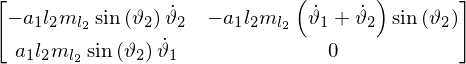

In [14]:
C = sym.zeros(2)

for k in range(2):
    for j in range(2):
        for i in range(2):
            C[k,j] += sym.Rational(1, 2) * (sym.diff(M[k,j], q[i]) + sym.diff(M[k,i], q[j]) - sym.diff(M[i,j], q[k])) * qd[i]

C.simplify()
C

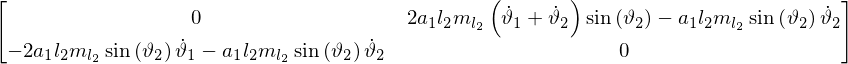

In [15]:
N = sym.diff(M, t) - 2*C
N.simplify()
N

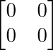

In [16]:
sym.simplify(-N - N.T)

### Potential energy
The potential energy can be expressed as a functions of the positions of the centers of mass. For the whole manipulator, this is
$$
V = \sum_{i=1}^n \mathbf{g}^T \mathbf{p}_{COM_i} m_i
$$

In [17]:
V = (g.T * T0com1[:3,3] * ml1) + (g.T * T0com2[:3,3] * ml2)

From the potiential energy we can set up a gravity function $g(\mathbf{q})$ as

$$
g_i(\mathbf{q}) = \frac{\partial V(\mathbf{q})}{\partial q_i} \\
g(\mathbf{q}) = [g_i, \dots g_n]^T
$$

This is the same as the mass of each link multiplied by its Jacobian, multiplied by the force of gravity, summed over each link
$$
g(\mathbf{q}) = \sum_{i=0}^n  J_{v_i}^T m_i \mathbf{g}
$$

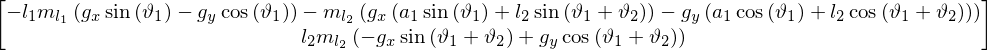

In [18]:
gq = sym.Matrix([sym.diff(V, theta) for theta in q])
#gq = Jcom1[:3,:].T * (ml1 * g) + Jcom2[:3,:].T * (ml2 * g)
gq.simplify()
gq

## Dynamic model simulation

The dynamic model (Euler-Lagrange equations) of the manipulator is
$$
M(q) \ddot{q} + C(q,\dot{q}) \dot{q} + D \dot{q} + g(q) = \tau
$$

Make into system of ODEs by introducing variables
\begin{align*}
y_0 &= q \\
y_1 &= \dot{q}
\end{align*}

Differentiating gives
\begin{align*}
y_0' &= \dot{q} = y_1 \\
y_1' &= \ddot{q} = M^{-1}(q)  \big(-C(q,\dot{q}) \dot{q} - D \dot{q} - g(q) + \tau \big)
\end{align*}

Thus the diff. eq. becomes
$$
\frac{d\mathbf{y}}{dt} = 
$$

In [19]:
# Friction
#D = sym.diag(15, 15)
D = sym.diag(0, 0)

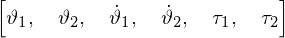

In [20]:
# Because lambdify seemingly can't handle substituting functions and their time derivatives
# at the same time, I manually replace time-varying functions with dummy symbols.

# In/outputs are flattened lists (as opposed to being lists of vectors).

dynamics = flatten([q, qd, tau])
dummy_symbols = [sym.Dummy() for _ in range(len(dynamics))]
dummy_dict = dict(zip(dynamics, dummy_symbols))

y1d_expr = (M.inv() * (-C*qd - D*qd - gq + tau)).subs(numeric_values).subs(dummy_dict)
y1d_eval = sym.lambdify(dummy_symbols, y1d_expr)

dynamics

In [21]:
def dydt(y, t):
    q_ = y[0:2]
    qd_ = y[2:4]
    tau_ = [0, 0]
    
    y0d = qd_
    y1d = y1d_eval(*flatten([q_, qd_, tau_]))
    
    return flatten([y0d, y1d])

In [22]:
y0 = flatten([[0, 0], [0, 0]])  # Initial conditions
ts = np.linspace(0, 20, 2000)  # Time vector
y = odeint(dydt, y0, ts)

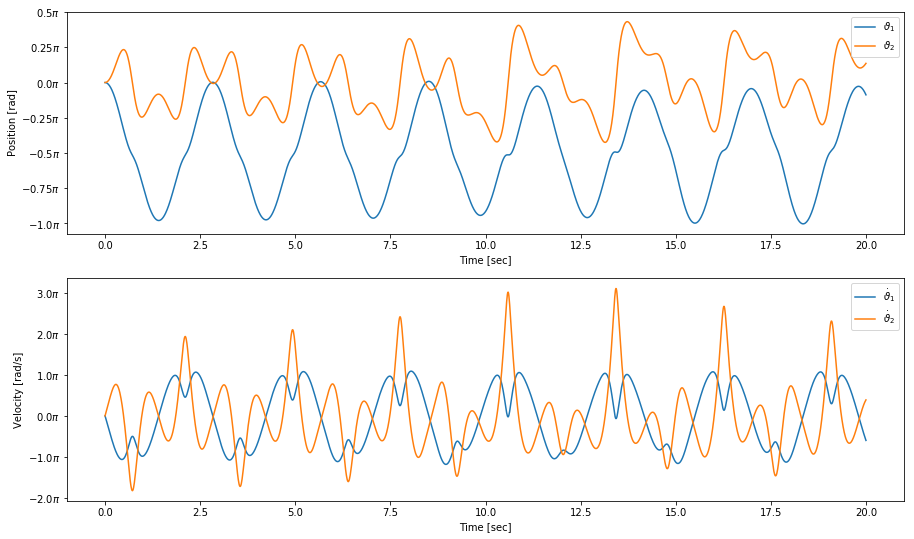

In [23]:
labels = ['${}$'.format(sym.physics.vector.vlatex(s)) for s in dynamics]
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,9))

ax1.plot(ts, y[:,0:2])
ax1.set_ylabel('Position [rad]')
ax1.set_xlabel('Time [sec]')
ticks_loc = np.linspace(-1, 0.5, 7)
ax1.set_yticks([x*np.pi for x in ticks_loc])
ax1.set_yticklabels(['${}\pi$'.format(x) for x in ticks_loc])
ax1.legend(labels[0:2], loc='upper right')

ax2.plot(ts, y[:,2:4])
ax2.set_ylabel('Velocity [rad/s]')
ax2.set_xlabel('Time [sec]')
ticks_loc = np.linspace(-2, 3, 6)
ax2.set_yticks([x*np.pi for x in ticks_loc])
ax2.set_yticklabels(['${}\pi$'.format(x) for x in ticks_loc])
ax2.legend(labels[2:4], loc='upper right')

plt.show()

## Animate

In [24]:
def animate(ts, y):
    from matplotlib import animation

    # Evaluate x,y translational part of transforms given 'q'
    point_eval = (sym.lambdify(q, T01[0:2,3].subs(numeric_values)),
                  sym.lambdify(q, T02[0:2,3].subs(numeric_values)), 
                  sym.lambdify(q, T03[0:2,3].subs(numeric_values)))

    fig = plt.figure()
    ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2), aspect='equal')
    time_text = ax.text(0.85, 0.9, '', transform=ax.transAxes)

    lines = []
    for i in range(2):
        l, = ax.plot([], [], lw=2)
        lines.append(l)

    def anim_init():
        time_text.set_text('')
        for l in lines:
            l.set_data([], [])
        return (*lines, time_text)

    def anim_step(i):
        time_text.set_text('{:2.2f} s'.format(ts[i]))
        for k in range(2):
            p_start = point_eval[k](*y[i,0:2]).flatten()
            p_end = point_eval[k+1](*y[i,0:2]).flatten()
            xs = [p_start[0], p_end[0]]
            ys = [p_start[1], p_end[1]]
            lines[k].set_data(xs, ys)
        return (*lines, time_text)

    anim = animation.FuncAnimation(fig, anim_step, init_func=anim_init, frames=len(ts), blit=True)
    anim.save('animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

#animate(ts, y)

In [25]:
from IPython.display import HTML

HTML("""
<video width="440" height="320" controls>
  <source src="animation.mp4" type="video/mp4">
</video>
""")

## Linearity of the dynamic model

The system (without friction)
$$
M(q) \ddot{q} + C(q,\dot{q}) \dot{q} + g(q) = \tau
$$
can be written as
$$
\tau = Y(q, \dot{q}, \ddot{q}) \phi
$$
where $Y$ is the regressor depending on joint positions, velocities and accelerations and $\phi$ is the parameter vector of dynamic coefficients.

In [26]:
M[0,0]

In [27]:
M[1,0]  # equal to M[0,1]

In [28]:
M[1,1]

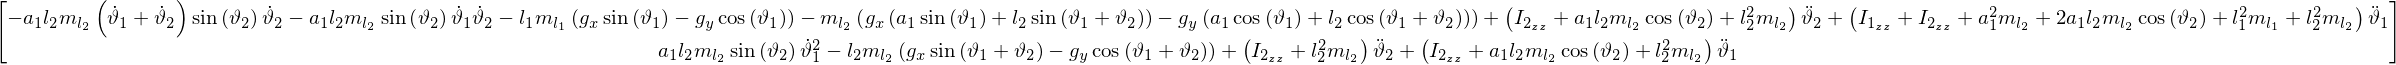

In [29]:
tau_test1 = M*qdd + C*qd + gq
tau_test1.simplify()
tau_test1

Working it out by hand gives

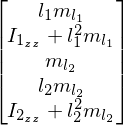

In [30]:
Il1zz = Il1[2,2]
Il2zz = Il2[2,2]

phi = sym.Matrix([
    ml1*l1,
    ml1*l1**2 + Il1zz,
    ml2,
    ml2*l2,
    ml2*l2**2 + Il2zz,
])

phi

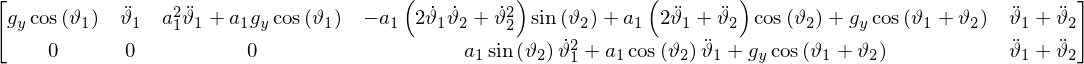

In [31]:
gx, gy, gz = g

Y = sym.zeros(2, 5)
Y[0,0] = gy * sym.cos(theta1)
Y[0,1] = theta1dd
Y[0,2] = a1**2*theta1dd + a1*gy*sym.cos(theta1)
Y[0,3] = a1*sym.cos(theta2)*(2*theta1dd + theta2dd) - a1*sym.sin(theta2)*(2*theta1d*theta2d + theta2d**2) + gy*sym.cos(theta1+theta2)
Y[0,4] = theta1dd + theta2dd
Y[1,3] = a1*sym.cos(theta2)*theta1dd + a1*sym.sin(theta2)*theta1d**2 + gy*sym.cos(theta1 + theta2)
Y[1,4] = theta1dd + theta2dd

Y

Test that they do in fact end up giving the same $\tau$

In [32]:
tau_test2 = Y*phi

In [33]:
sym.simplify(tau_test2 - tau_test1.subs({gx:0}))

## Parameter estimation
First, trajectory parameterization as a finite Fourier series

In [34]:
N = sym.symbols('N', integer=True)
i, k = sym.symbols('i, k', cls=sym.Idx)
t, wf = sym.symbols('t, omega_f', real=True)
a = sym.IndexedBase('a')
b = sym.IndexedBase('b')
c = sym.IndexedBase('c')

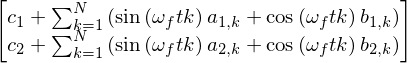

In [48]:
q_i = c[i] + sym.Sum(a[i,k]*sym.sin(k*wf*t) + b[i,k]*sym.cos(k*wf*t), (k,1,N))
q = sym.Matrix([q_i.subs({i: j}) for j in range(1,3)])
q

In [47]:
subz = {wf: 2}
subz.update({a[1,j+1]: x for j, x in enumerate([1, 1])})
subz.update({a[2,j+1]: x for j, x in enumerate([5, 1])})
subz.update({b[1,j+1]: x for j, x in enumerate([2, 2])})
subz.update({b[2,j+1]: x for j, x in enumerate([2, 2])})
subz.update({c[j+1]: x for j, x in enumerate([9, 7])})
subz

In [50]:
#varz = [t, q0[1], q0[2]]
#dummy_symbols = [sym.Dummy() for _ in range(len(varz))]
#dummy_dict = dict(zip(varz, dummy_symbols))

q_expr = q.subs({N:2}).doit().subs(subz) #.subs(dummy_dict)
q_eval = sym.lambdify(t, q_expr)

In [51]:
ts = np.linspace(0, 10, 1000)
y = np.squeeze([q_eval(x) for x in ts])
yd = np.gradient(y, axis=0)
ydd = np.gradient(yd, axis=0)

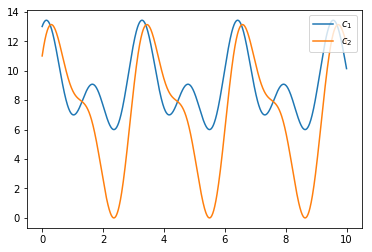

In [53]:
plt.plot(ts, y)
plt.legend(['${}$'.format(sym.printing.latex(s)) for s in [c[1], c[2]]], loc='upper right')
plt.show()

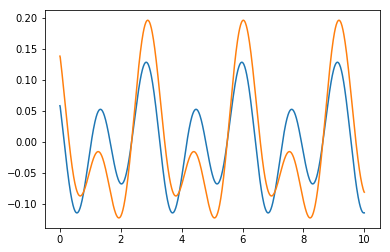

In [54]:
plt.plot(ts, yd)
plt.show()

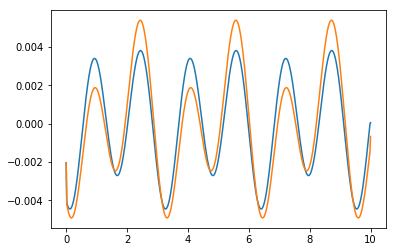

In [55]:
plt.plot(ts, ydd)
plt.show()